# Transfer Learning

This notebook is used to create a UNET with a Resnet18 as a backbone with the timm library. 

In [1]:
import os
import time
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from fastcore.xtras import Path

from fastai.data.block import DataBlock
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.losses import CrossEntropyLossFlat

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.all import Learner
from fastai.vision.all import L
from fastai.vision.all import params
from fastai.vision.all import total_params

import torch

#### Define some paths for later use.

In [2]:
repo_path = os.path.dirname(os.path.abspath(''))
data_path = os.path.join(repo_path, 'data')
src_path = os.path.join(repo_path, 'src')
path_im = os.path.join(data_path, 'Images')

#### Get the path including the filename of alls images

In [3]:
fnames = get_image_files(path_im)

#### Randomly select 20% of the images as validation images and 20% as test images
Furthermore the names of the validation images get saved to the valid.txt file so that the DataBlock can split the data

In [4]:
fnames_array = np.array(fnames)

np.random.seed(5)
np.random.shuffle(fnames_array)

train_fnames, valid_fnames, test_fnames = np.split(fnames_array, [int(0.6*len(fnames_array)), int(0.8*len(fnames_array))])

train_val_fnames = np.concatenate((train_fnames, valid_fnames))

valid_fnames = [str(abs_path).split('/')[-1] for abs_path in valid_fnames]
np.savetxt(os.path.join(data_path, 'valid.txt'), valid_fnames, fmt='%s')


#### Define a function that will supply the DataBlock with the imagenames 

In [5]:
def get_train_files(path_im):
    train_data = list()
    for i in train_val_fnames:
        train_data.append(Path(i))
    return train_data   

#### Let's have a look at an image example

<AxesSubplot: >

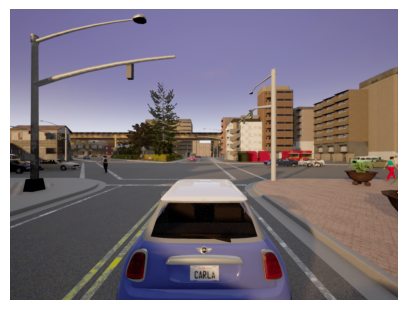

In [6]:
img_fn = test_fnames[0]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

#### Define a lambda function to get the path to a mask for a given image

In [7]:
get_msk = lambda o: str(o.absolute()).replace('Images', 'Labels_int')

#### Let's have a look at the mask of the previous image

<AxesSubplot: >

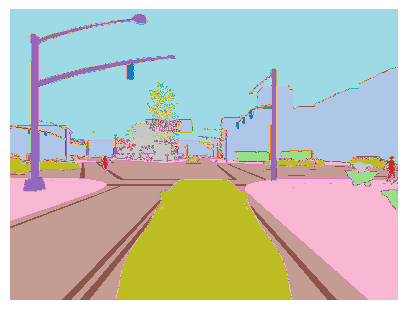

In [8]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [9]:
print(tensor(msk))
lbl_img = get_msk(img_fn)

tensor([[12, 12, 12,  ..., 12, 12, 12],
        [12, 12, 12,  ..., 12, 12, 12],
        [12, 12, 12,  ..., 12, 12, 12],
        ...,
        [ 7,  7,  7,  ...,  8,  8,  8],
        [ 7,  7,  7,  ...,  8,  8,  8],
        [ 7,  7,  7,  ...,  8,  8,  8]], dtype=torch.uint8)


#### Define a list containing the color values of the different classes in the masks and an array containing the names of the different classes

In [10]:
VOC_COLORMAP = [
    [0, 220, 220], [70, 70, 70], [153, 153, 190], [160, 170, 250],
    [60, 20, 220], [153, 153, 153], [50, 234, 157], [128, 64, 128],
    [232, 35, 244], [35, 142, 107], [142, 0, 0], [156, 102, 102], [0, 0, 0]
]

VOC_CLASSES = np.array([
    'Traffic Sign', 'Building', 'Fence', 'Other', 'Pedestrian', 'Pole', 'Road Line',
    'Road', 'Sidewalk', 'Vegetation', 'Car', 'Wall', 'Unlabeled'
])

#### Define a function that splits the dataset into training and validation data

In [11]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

#### Get the size of the images

In [12]:
sz = msk.shape
sz

(600, 800)

#### Use the DataBlock of the fastai API to get the data into a dataloader
This is also were the augmentation, normalization and resizing of the images is defined

In [13]:
david = DataBlock(blocks=(ImageBlock, MaskBlock(VOC_CLASSES)),
                 get_items=get_train_files,
                 splitter=FileSplitter(os.path.join(data_path, 'valid.txt')),
                 get_y=get_msk,
                 batch_tfms=[*aug_transforms(size=(608,800)), Normalize.from_stats(*imagenet_stats)])

#### Get the dataloaders 
We use a batchsize of 2

In [14]:
dls = david.dataloaders(os.path.join(data_path, 'Images'), bs=2)

#### Let's have a look at some images from the dataloader

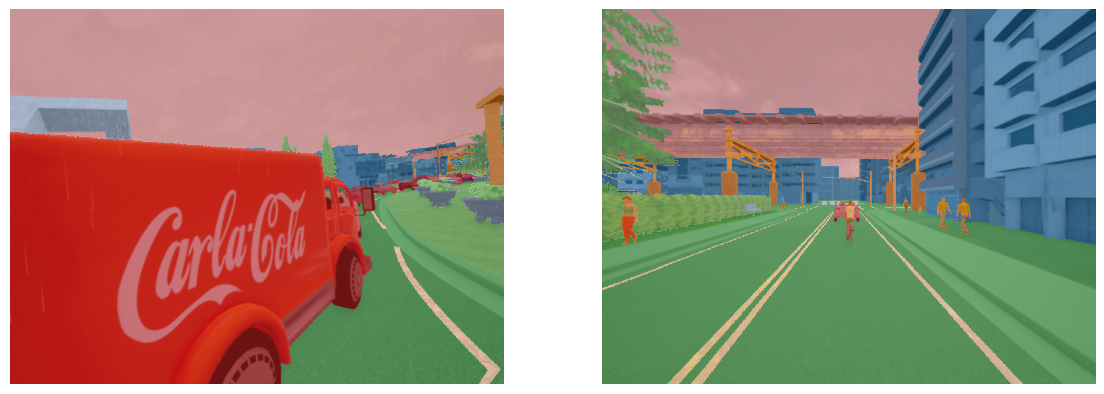

In [15]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

#### Create a dictionary containing the class names and their corresponding ids

In [16]:
dls.vocab = VOC_CLASSES
name2id = {label:id for id,label in enumerate(VOC_CLASSES)}
name2id

{'Traffic Sign': 0,
 'Building': 1,
 'Fence': 2,
 'Other': 3,
 'Pedestrian': 4,
 'Pole': 5,
 'Road Line': 6,
 'Road': 7,
 'Sidewalk': 8,
 'Vegetation': 9,
 'Car': 10,
 'Wall': 11,
 'Unlabeled': 12}

#### Define the 'Unlabeled' class as the void_code 

In [17]:
void_code = name2id['Unlabeled']
void_code
del name2id['Unlabeled']

#### Custom splitter to apply Discriminative learning

In [18]:
def unet_splitter(m): return L(m.encoder,m.decoder).map(params)

#### Create weights for a weighted loss func



In [19]:
WEIGHTED_LOSS_FUNC = False

if not WEIGHTED_LOSS_FUNC:
    loss_func = CrossEntropyLossFlat(axis=1)
else:
    class_counts = np.zeros(13).astype(int)
    
    for name in train_fnames:
        msk_tensor = tensor(PILMask.create(get_msk(name)))
        unique_values, counts = np.unique(msk_tensor, return_counts=True)
        for i in range(len(counts)):
            class_counts[unique_values[i]] += counts[i]

    weights = np.mean(class_counts) / class_counts
    sqrt_weights = np.sqrt(weights)

    for i in range(len(class_counts)):
        print('class {} weight / sqrt_weight: {} / {}'.format(VOC_CLASSES[i], weights[i], sqrt_weights[i]))

    weights = torch.tensor(sqrt_weights.astype(np.float32)).cuda()

    loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

class Traffic Sign weight / sqrt_weight: 73.83049500207969 / 8.592467340763053
class Building weight / sqrt_weight: 0.6458599822110914 / 0.8036541434044197
class Fence weight / sqrt_weight: 75.14603694168932 / 8.6686813842527
class Other weight / sqrt_weight: 11.616393577535856 / 3.408283083538669
class Pedestrian weight / sqrt_weight: 23.367668473501517 / 4.834011633571181
class Pole weight / sqrt_weight: 5.038995098036013 / 2.2447706114514268
class Road Line weight / sqrt_weight: 4.650021866040019 / 2.1563909353454487
class Road weight / sqrt_weight: 0.2414228193169005 / 0.49134796154751725
class Sidewalk weight / sqrt_weight: 1.612103802699747 / 1.2696864978016216
class Vegetation weight / sqrt_weight: 2.187428494215407 / 1.4789957722101192
class Car weight / sqrt_weight: 0.8923121152821888 / 0.9446227370131363
class Wall weight / sqrt_weight: 3.048762193801252 / 1.746070500810678
class Unlabeled weight / sqrt_weight: 0.2372941690186654 / 0.487128493334834


#### Define a accuracy metric

In [20]:
def acc_david(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

## Training our Unet
#### Define our model and show the summary

In [21]:
from model_architecture import Unet

learn = Learner(dls,Unet(fs=32,expansion=1,model_name='resnet18',n_out=13),loss_func=loss_func, metrics=acc_david, splitter=unet_splitter)

learn.summary()


13


Unet (Input shape: 2 x 3 x 608 x 800)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 64 x 304 x 400  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     2 x 64 x 152 x 200  
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                                                       
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                             

#### Training
We're freezing the encoder for 2 epochs and than train the whole net for 4 epochs

In [22]:
start_time = time.perf_counter()
learn.fine_tune(4, freeze_epochs=2)
model_runtime = time.perf_counter() - start_time

epoch,train_loss,valid_loss,acc_david,time
0,0.279326,0.241740,0.935609,10:15
1,0.170968,0.149349,0.958175,10:16


epoch,train_loss,valid_loss,acc_david,time
0,0.135243,0.132051,0.961232,10:53
1,0.119429,0.109558,0.967022,10:54
2,0.108008,0.099904,0.968374,10:54
3,0.100519,0.096462,0.969840,10:54


#### Save and/or load the model

In [23]:
if WEIGHTED_LOSS_FUNC:
    learn.save(os.path.join(src_path, 'models', 'timm_resnet18_unet_weighted-loss'))
    learn.load(os.path.join(src_path, 'models', 'timm_resnet18_unet_weighted-loss'), with_opt=False, device='cuda')
else:
    learn.save(os.path.join(src_path, 'models', 'timm_resnet18_unet'))
    learn.load(os.path.join(src_path, 'models', 'timm_resnet18_unet'), with_opt=False, device='cuda')

#### Show some results with the prediction on the right and the corresponding target on the left

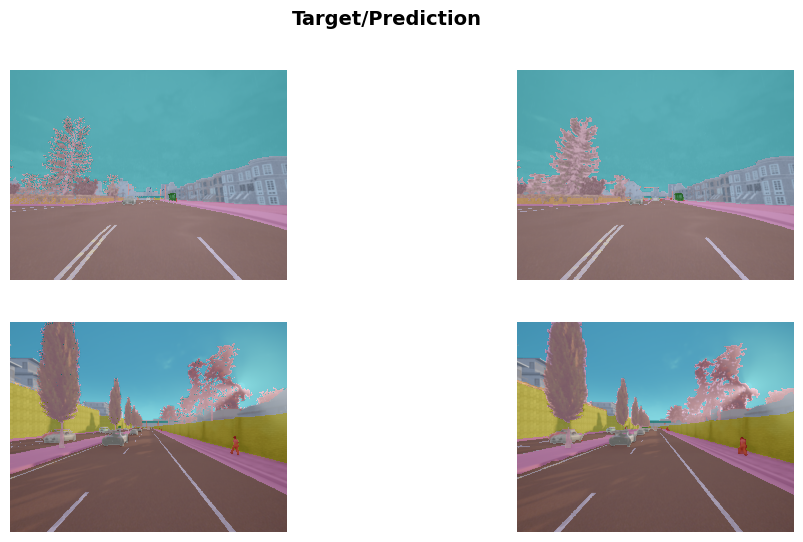

In [24]:
learn.show_results(max_n=4, figsize=(12,6))

## Let's do some inference with the trained model

#### Define some functions for the following inference

In [25]:
def calc_classwise_recall(inp,targ):
    temp_result= []
    targ = targ.squeeze(1)
    inp = inp.argmax(dim=1)
    for key, value in name2id.items():
        mask = (targ == value)
        inp_values = inp[mask]
        temp_result.append([mask.sum(), (inp_values == value).sum()])
    return temp_result

def calc_classwise_precision(inp, targ):
    temp_result= []
    targ = targ.squeeze(1)
    inp = inp.argmax(dim=1)
    for key, value in name2id.items():
        mask = (inp == value)
        targ_values = targ[mask]
        temp_result.append([mask.sum(), (targ_values == value).sum()])
    return temp_result

def predict_on_batch(dl):
    preds, _ = learn.get_preds(dl=dl)
    if preds.shape[2] == 608:
        correct_size_preds = preds[:,:,4:-4,:]
    else:
        correct_size_preds = preds
    return correct_size_preds

#### Get images from the test_dl

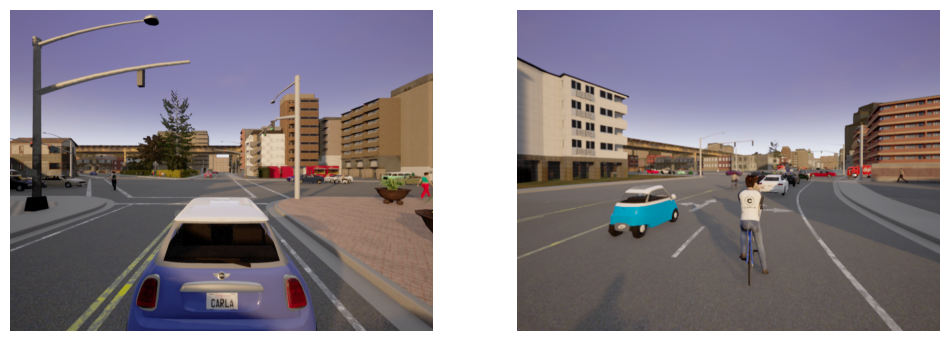

In [26]:
dl = learn.dls.test_dl(test_fnames[:2])
dl.show_batch(figsize=(12,6))

#### Predict on the two previous images and select first prediction

In [27]:
preds = predict_on_batch(dl=dl)
pred_1 = preds[0]
pred_1.shape

torch.Size([13, 600, 800])

#### Visualize the target / ground truth and the predicted mask

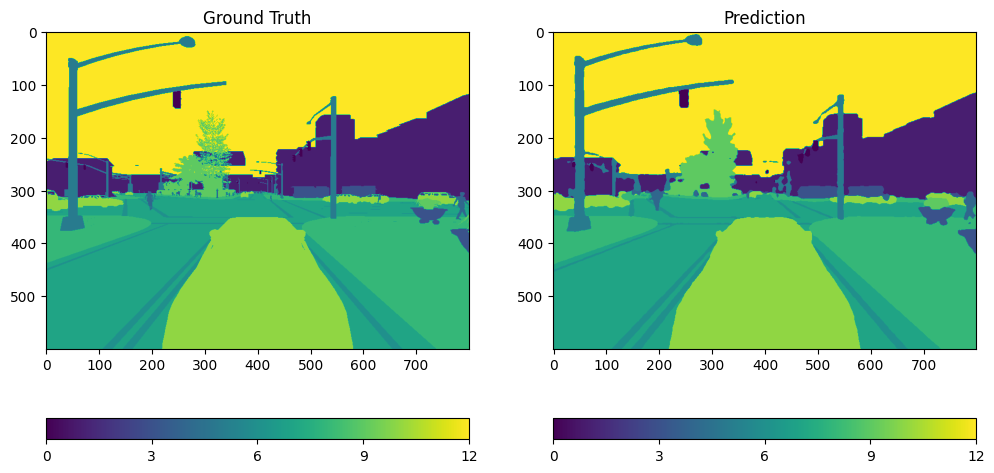

In [28]:
pred_arx = pred_1.argmax(dim=0)
gt = (mpimg.imread(get_msk(test_fnames[0]))*255).astype(int)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(gt)
plt.colorbar(ticks=[0, 3, 6, 9, 12], orientation='horizontal')
ax.set_title('Ground Truth')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(pred_arx)
plt.colorbar(ticks=[0, 3, 6, 9, 12], orientation='horizontal')
ax.set_title('Prediction')
plt.show()

#### Visualize all incorrect labeled pixels 
All white pixels were predicted correct while the black pixels represent an incorrect labeled pixel

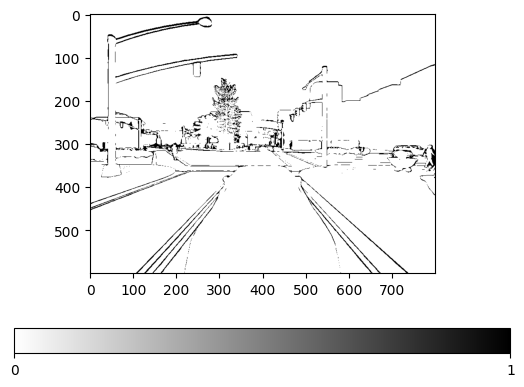

In [29]:
difference_gt_pred = abs(gt - np.array(pred_arx))
difference_gt_pred[difference_gt_pred > 0] = 1
imgplot = plt.imshow(difference_gt_pred, cmap='gray_r')
plt.colorbar(ticks=[0, 1], orientation='horizontal')
imgplot.set_clim(0, 1)
plt.show()

#### Predict on the testdata to retrive our metrics

In [30]:
from IPython.utils import io
from tqdm import tqdm

test_fnames_batches = np.array_split(test_fnames, 200)

class_occurence = np.zeros(12, dtype=np.int64)
class_true_positive = np.zeros(12, dtype=np.int64)
accuracy = list()
class_labled = np.zeros(12, dtype=np.int64)
class_true_positive_prec = np.zeros(12, dtype=np.int64)

with tqdm(total=len(test_fnames_batches)) as pbar:
    for batch in test_fnames_batches:
        pbar.update(1)

        dl = learn.dls.test_dl(batch)
        with io.capture_output() as captured:
            preds = predict_on_batch(dl=dl)
        
        for sample in range(preds.shape[0]):
            targ_path = get_msk(batch[sample])
            target = (mpimg.imread(targ_path)*255).astype(int)

            target = tensor(target[None,None,:,:])
            prediction = preds[sample][None,:,:,:]

            accuracy.append(acc_david(prediction, target))
            recall_list = calc_classwise_recall(prediction, target)
            precision_list = calc_classwise_precision(prediction, target)

            for id, result in enumerate(recall_list):
                class_occurence[id] = class_occurence[id] + result[0]
                class_true_positive[id] = class_true_positive[id] + result[1]

            for id, result in enumerate(precision_list):
                class_labled[id] = class_labled[id] + result[0]
                class_true_positive_prec[id] = class_true_positive_prec[id] + result[1]

100%|██████████| 200/200 [04:57<00:00,  1.49s/it]


#### Print our key metrics

In [31]:
print('Accuracy: {} \n'.format(np.array(accuracy).mean()))
classwise_recall = list()
classwise_precision = list()

for label in range(len(name2id)):
    print('Accuracy of {}: {}'.format(VOC_CLASSES[label], (class_true_positive[label]/class_occurence[label])))
    print('Precision of {}: {} \n Appeared {} times'.format(VOC_CLASSES[label], (class_true_positive_prec[label]/class_labled[label]), class_occurence[label]))
    print('True positive 1: {} \n True positive 2: {}'.format(class_true_positive[label], class_true_positive_prec[label]))
    classwise_recall.append(float(class_true_positive[label]/class_occurence[label]))
    classwise_precision.append(float((class_true_positive_prec[label]/class_labled[label])))
                                                                               

Accuracy: 0.9585780501365662 

Accuracy of Traffic Sign: 0.9353203613634011 
 Appeared 1033973 times
Accuracy of Building: 0.9533772579997292 
 Appeared 117018836 times
Accuracy of Fence: 0.9325317611736355 
 Appeared 860642 times
Accuracy of Other: 0.95445087858257 
 Appeared 6496942 times
Accuracy of Pedestrian: 0.9095558565981134 
 Appeared 3029472 times
Accuracy of Pole: 0.8713843095357234 
 Appeared 14788600 times
Accuracy of Road Line: 0.7891722036402599 
 Appeared 16549203 times
Accuracy of Road: 0.9694812229048428 
 Appeared 315299888 times
Accuracy of Sidewalk: 0.9615705302248491 
 Appeared 46799787 times
Accuracy of Vegetation: 0.9481988112572374 
 Appeared 34515289 times
Accuracy of Car: 0.9770638378490687 
 Appeared 84068293 times
Accuracy of Wall: 0.9716650728367731 
 Appeared 25403171 times


#### Save information on our nets in a json for later evaluation 

In [32]:
results = {}
results['accuracy_mean'] = np.array(accuracy).mean().item()
results['model_runtime'] = model_runtime
results['total_params'] = total_params(learn)
results['classwise_recall'] = classwise_recall 
results['accuracy'] = [float(acc) for acc in accuracy]
results['classwise_precision'] = classwise_precision

if WEIGHTED_LOSS_FUNC:
    with open(src_path + '/models/resnet18/results_weighted-loss.json', 'w') as f:
        json.dump(results, f)
else:
    with open(src_path + '/models/resnet18/results.json', 'w') as f:
        json.dump(results, f)